# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [1]:
%load_ext autoreload
%autoreload 2

import cProfile as profile
import numpy as np
import pandas as pd
import time

from benchmarks.generator import get_revenue_behaviour
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, TrainSchedulePlotter, infer_line_stations, get_services_by_tsp_df
from src.entities import Solution

from robin.kernel.entities import Kernel
from robin.plotter.entities import KernelPlotter
from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from tqdm.notebook import tqdm
from typing import List, Union
import shutil

In [4]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

In [5]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 3


In [6]:
global_train_hist = pd.DataFrame()
runs_best_solution_history = {}
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)
print(f"Total services: {len(supply.services)}")

      Number of Services
AVLO                   1
IRYO                   1
AVE                    1
Total services: 3


Services:  3


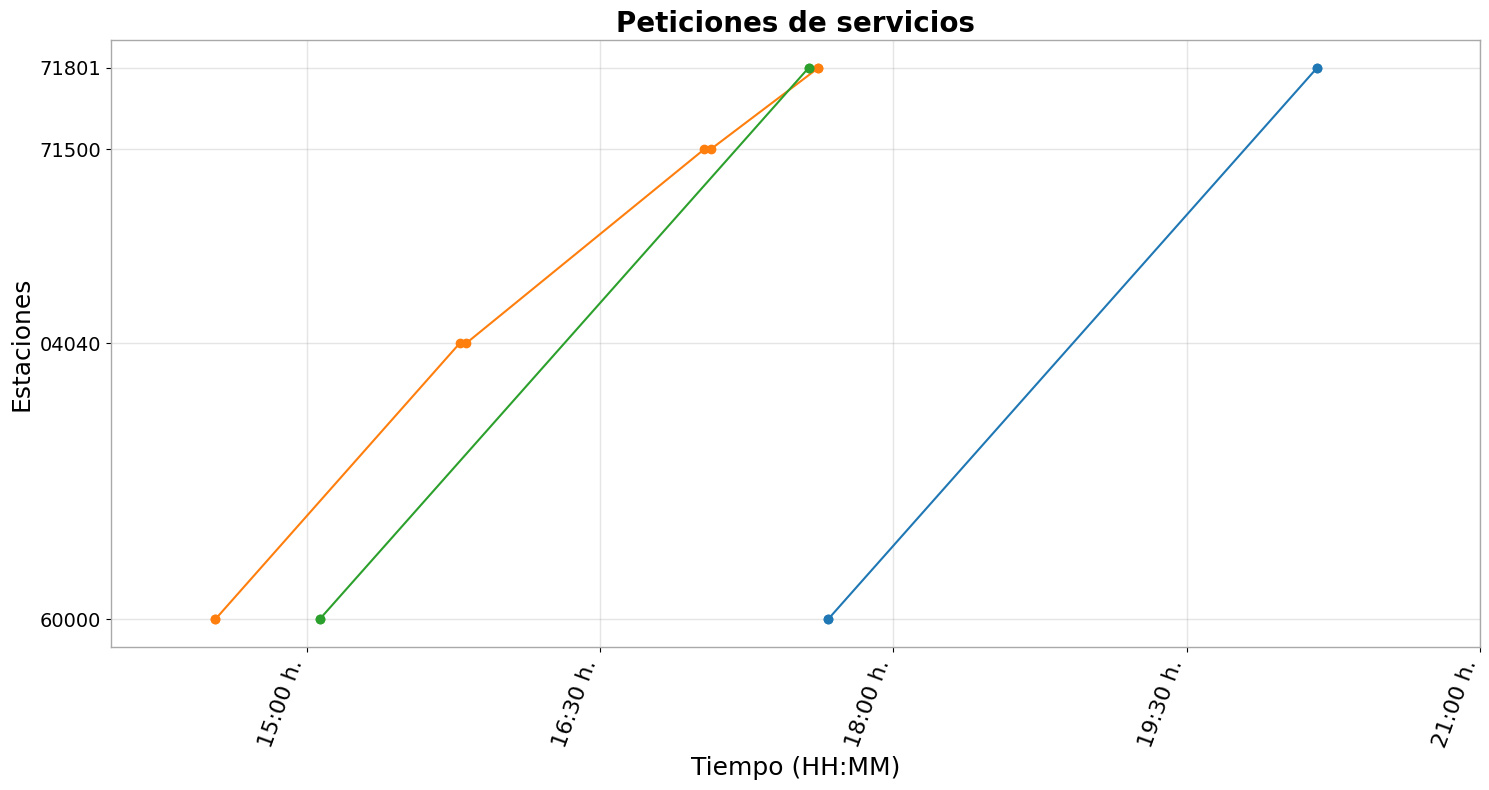

In [7]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behaviour(requested_schedule)
lines = supply.lines
line = infer_line_stations(lines)

plotter = TrainSchedulePlotter(requested_schedule, line)
plotter.plot(main_title="Peticiones de servicios")

In [15]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                             revenue_behaviour=revenue_behaviour,
                             line=line,
                             safe_headway=10)

In [22]:
from copy import deepcopy

ot_idx = 0
proposed_times = deepcopy(sm.requested_times)
updated_boundaries = deepcopy(sm.boundaries.real)
for j in range(len(sm.requested_times)):
    lower_bound, upper_bound = updated_boundaries[j]
    proposed_times[j] = int(np.random.uniform(lower_bound, upper_bound))
    ot_idx, updated_boundaries = sm._update_dynamic_bounds(j, ot_idx, proposed_times, updated_boundaries)

print(proposed_times)

[1061, 870, 947, 1028, 899]


In [36]:
from copy import deepcopy
import numpy as np

def generate_combinations(index, ot_idx, current_vector, boundaries, all_combinations):
    if index == len(current_vector):
        # If the current vector is complete, add it to the list of all combinations
        all_combinations.append(deepcopy(current_vector))
        return

    lower_bound, upper_bound = boundaries[index]
    # Iterates over the possible values for the current element
    for value in range(lower_bound, upper_bound + 1):
        current_vector[index] = value
        # Update the boundaries for the next element
        _, updated_boundaries = sm._update_dynamic_bounds(index, ot_idx, current_vector, deepcopy(boundaries))
        generate_combinations(index + 1, ot_idx, current_vector, updated_boundaries, all_combinations)

# Initialize variables
initial_vector = deepcopy(sm.requested_times)
boundaries = deepcopy(sm.boundaries.real)
all_combinations = []

generate_combinations(0, 0, initial_vector, boundaries, all_combinations)

# Imprimir todas las combinaciones posibles
print(len(all_combinations))

392931


In [40]:
best_solution = None
best_fitness = -np.inf

for i, combination in enumerate(tqdm(all_combinations)):
    if not sm.feasible_services_times(Solution(real=np.array(combination), discrete=np.array([]))):
        continue
    fitness, _ = sm.get_fitness_gsa(Solution(real=np.array(combination), discrete=np.array([])), heuristic_schedule=False)
    if fitness > best_fitness:
        best_fitness = fitness
        best_solution = combination

  0%|          | 0/392931 [00:00<?, ?it/s]

In [51]:
import multiprocessing

def func(index: int):
    print(index)

manager = multiprocessing.Manager()
processes = []

for i in range(-1, 10):
    p = multiprocessing.Process(target=func, args=(i,))
    processes.append(p)
    p.start()

for process in processes:
    process.join()

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'func' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, 

In [32]:
print(f"Best solution: {best_solution}")
print(f"Best fitness: {best_fitness}")

Best solution: [1060, 871, 948, 1025, 894]
Best fitness: 409.6487976742191


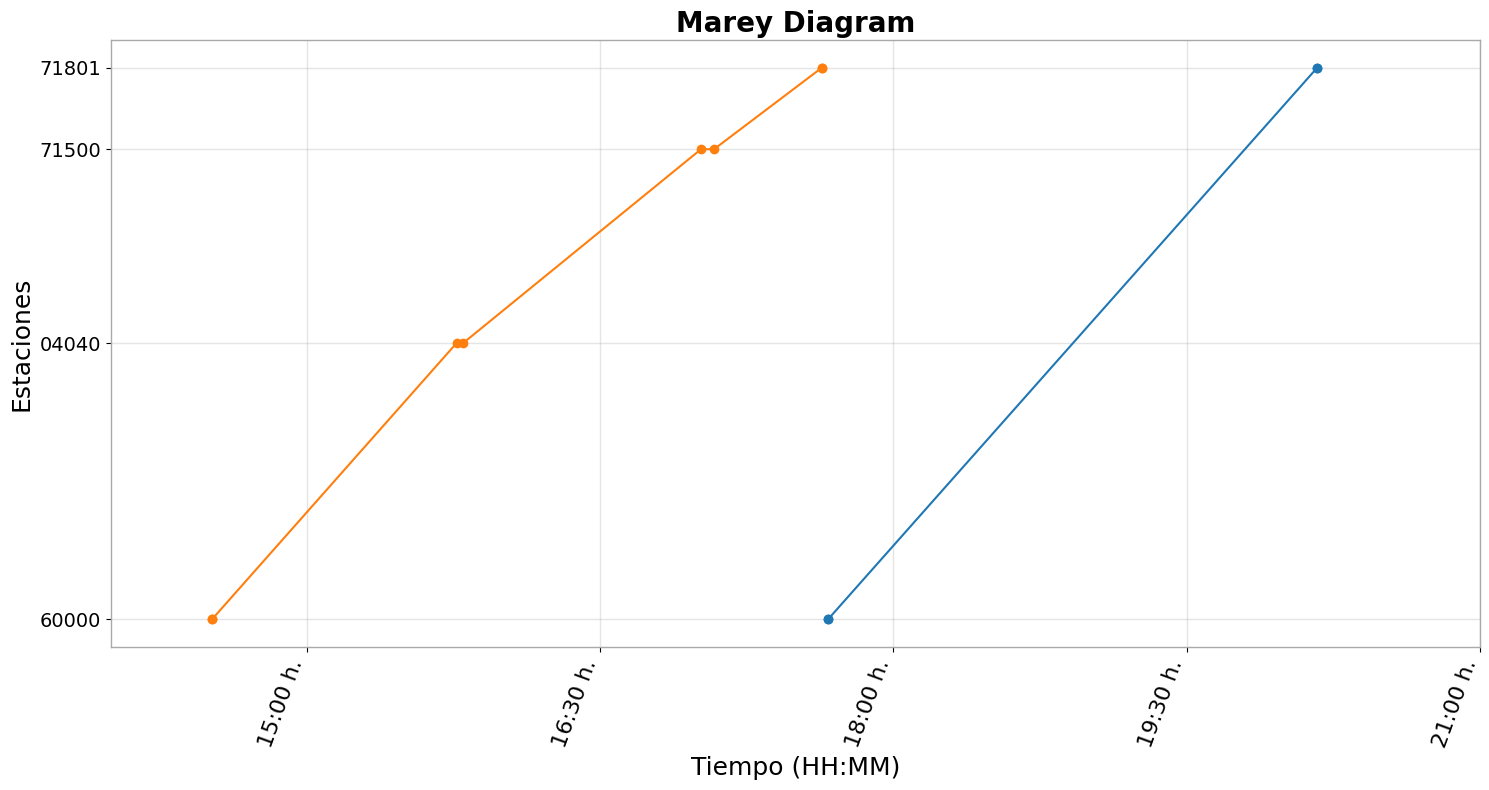

In [33]:

real_solution = Solution(real=np.array(best_solution), discrete=np.array([]))
solution = Solution(real=np.array(best_solution), discrete=sm.get_heuristic_schedule(real_solution))

services = sm.update_supply(path=generator_save_path,
                            solution=solution)

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if solution.discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

plotter = TrainSchedulePlotter(filtered_services, line)
plotter.plot(save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)
supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

Data from demand plot: 
	Status: User found  any service that met his needs but couldn't purchase. - Passengers: 5405
	Status: User bought a service which was not the one with the best utility. - Passengers: 2372
	Status: User bought the ticket with best utility. - Passengers: 931
	Status: User didn't find any ticket that met his needs. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  3303
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 239 - Percentage: 7.24 %
		Seat: Turista - Passengers: 1977 - Percentage: 59.85 %
		Seat: TuristaPlus - Passengers: 1087 - Percentage: 32.91 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  3303
	Tickets sold by purchase date and seat type: 
		Date: 2023-06-11
			Seat: Premium - Number of tickets sold: 20
			Seat: Turista - Number of tickets sold: 61
			Seat: TuristaPlus - Number of tickets sold: 69
		Date: 2023-06-12
			Seat: Premium - Number of tickets sold: 14
			Seat: Turista - Number of tic

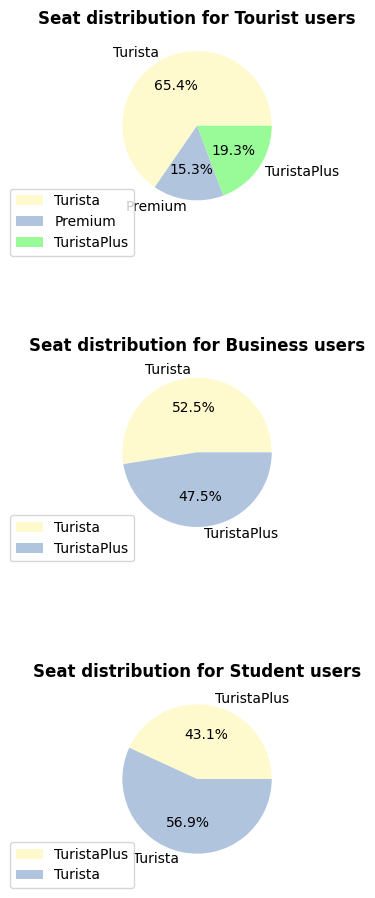

In [17]:
# Simulate market
kernel = Kernel(path_config_supply=supply_config_path,
                path_config_demand=demand_config_path)

services = kernel.simulate(output_path=Path(f'{robin_save_path}output.csv'), departure_time_hard_restriction=True)

kernel_plotter = KernelPlotter(path_output_csv=Path(f'{robin_save_path}output.csv'),
                               path_config_supply=supply_config_path)

kernel_plotter.plotter_data_analysis()
kernel_plotter.plot_users_seat_pie_chart(save_path='../figures/users_seat_pie_chart.pdf')

In [15]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fdavid%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat
^C

Bye!
